## Purpose

This notebook implements ADDA ( https://arxiv.org/pdf/1702.05464.pdf ), with MNIST and USPS data.

The algorithm works as follows:

1. **Pre-training:** We train embeddings + a classifier for the source dataset

2. **Adversial adaptation:** We train a GAN with the embeddings CNN for the source and target datasets. In this part we freeze the source CNN so that the target embeddings are learnt so that the discriminator does not know if the data belongs to the source or target dataset.

3. **Testing:** For testing, we use the target embeddings +  the source classifier.




In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!git clone https://github.com/NuriaSF/ML_DomainAdaptation

fatal: destination path 'ML_DomainAdaptation' already exists and is not an empty directory.


In [3]:
cd ML_DomainAdaptation/GAN


/content/ML_DomainAdaptation/GAN


In [4]:
ls

ADDA.ipynb              source_discriminator.hdf5  usps_dataset.h5
source_classifier.hdf5  target_discriminator.hdf5


In [5]:
import tensorflow as tf
import math
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import layers
from keras import models
from keras.models import Model,Sequential,clone_model
from keras import backend as K
from keras.regularizers import Regularizer
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
from keras.utils import np_utils
import keras
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np
import h5py

Using TensorFlow backend.


## Data

Let us begin by loading and preprocessing the source data: MNIST

In [0]:
(source_train_images, source_train_labels), (source_test_images, source_test_labels) = mnist.load_data()

In [0]:
source_train_images = source_train_images.reshape((60000, 28, 28, 1))
source_train_images = source_train_images.astype('float32') / 255

source_test_images = source_test_images.reshape((10000, 28, 28, 1))
source_test_images = source_test_images.astype('float32') / 255

source_train_labels = to_categorical(source_train_labels)
source_test_labels = to_categorical(source_test_labels)

Let us now load and preprocess the target data: USPS

In [0]:
with h5py.File('usps_dataset.h5', 'r') as hf:
        train = hf.get('train')
        target_train_images_aux = train.get('data')[:]
        target_train_labels = train.get('target')[:]
        test = hf.get('test')
        target_test_images_aux = test.get('data')[:]
        target_test_labels = test.get('target')[:]

In [0]:
target_train_images = []
target_test_images = []

for i in range(7291):
    img = target_train_images_aux[i].reshape(16,16)
    img = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    target_train_images.append(img.flatten())
    
for i in range(2007):
    img = target_test_images_aux[i].reshape(16,16)
    img = cv2.resize(img, dsize=(28, 28), interpolation=cv2.INTER_CUBIC)
    target_test_images.append(img.flatten())

In [0]:
#convert list to numpy arrays
target_train_images = np.asarray(target_train_images)
target_test_images = np.asarray(target_test_images)

#train images
target_train_images = target_train_images.reshape((7291, 28, 28, 1))
target_train_images = target_train_images.astype('float32')
for i in range(7291):
    min_aux = np.min(target_train_images[i])
    max_aux = np.max(target_train_images[i]-min_aux)
    target_train_images[i] = (target_train_images[i]-min_aux)/max_aux

#test images
target_test_images = target_test_images.reshape((2007, 28, 28, 1))
target_test_images = target_test_images.astype('float32')
for i in range(2007):
    min_aux = np.min(target_test_images[i])
    max_aux = np.max(target_test_images[i]-min_aux)
    target_test_images[i] = (target_test_images[i]-min_aux)/max_aux

#labels
target_train_labels = to_categorical(target_train_labels)
target_test_labels = to_categorical(target_test_labels)

## Pre-training

We train a CNN which extracts embeddings from the source dataset. 

In [11]:
source_encoder = Sequential()

#Input
inp = Input(shape=(28, 28, 1))

#CNN layer +  relu
x = Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='same')(inp)
#Max pooling
x = MaxPooling2D(pool_size=(2, 2))(x)

#CNN layer + relu
x = Conv2D(48, kernel_size=(5, 5), activation='relu', padding='same')(x)
#Max pooling
x = MaxPooling2D(pool_size=(2, 2))(x)

#CNN layer + relu
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
#Max pooling
x = MaxPooling2D(pool_size=(2, 2))(x)

#Flatten

x = Flatten()(x)

source_encoder = Model(inputs=(inp), outputs=(x))
source_encoder.summary()





Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 48)        38448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 48)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          27712     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          

Now we define the classifier (some dense layers)

In [12]:
shape = source_encoder.output_shape[1:]

#Source discriminator
inp = Input(shape=shape)

x = Dense(256, activation='relu')(inp)
x = Dense(84, activation='relu')(x)
x = Dense(10, activation='softmax')(x)

classifier_model = Model(inputs=(inp), outputs=(x))

classifier_model.summary()

source_classifier_model = Model(inputs =(source_encoder.input), outputs = (classifier_model(source_encoder.output)))

source_classifier_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               147712    
_________________________________________________________________
dense_2 (Dense)              (None, 84)                21588     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                850       
Total params: 170,150
Trainable params: 170,150
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
____________________________________

Now we train the source model

In [13]:
lr = 0.001
save_interval = 1
epochs = 10

source_classifier_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=lr)
                                , metrics=['accuracy'])


saver = keras.callbacks.ModelCheckpoint('source_classifier.hdf5', 
                                        monitor='val_loss', 
                                        verbose=1, 
                                        save_best_only=False, 
                                        save_weights_only=True, 
                                        mode='auto')

scheduler = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=10, verbose=0, mode='min')

hist = source_classifier_model.fit(source_train_images,source_train_labels,
                            epochs=epochs,
                            callbacks=[saver, scheduler], 
                            validation_data=[source_test_images, source_test_labels])




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/10





60000/60000 [==============================] - 18s 292us/step - loss: 0.1384 - acc: 0.9568 - val_loss: 0.0365 - val_acc: 0.9895

Epoch 00001: saving model to source_classifier.hdf5
Epoch 2/10
60000/60000 [==============================] - 15s 248us/step - loss: 0.0465 - acc: 0.9859 - val_loss: 0.0584 - val_acc: 0.9820

Epoch 00002: saving model to source_classifier.hdf5
Epoch 3/10
60000/60000 [==============================] - 14s 237us/step - loss: 0.0325 - acc: 0.9904 - val_loss: 0.0258 - val_acc: 0.9919

Epoch 00003: saving model to source_classifier.hdf5
Epoch 4/10
60000/60000 [==============================] - 15s 242us/step - loss: 0.0269 - acc: 0.9919 - val_loss: 0.0225 - val_acc: 0.9930

Epoch 00004: saving model to source_classifier.hdf5
Epoch 5/10
60000/60000 [==============================] - 15s 242us/step - los

In [14]:
test_loss, test_acc = source_classifier_model.evaluate(source_test_images, source_test_labels)

10000/10000 [==============================] - 1s 72us/step


In [15]:
print('test accuracy: ', test_acc)
print('test loss: ', test_loss)

test accuracy:  0.9924
test loss:  0.03101448710427212


## Adversial adaptation

In this step, we train a CNN which produces embeddings for the target dataset. We also train a discriminator to distinguish the source and target data. For this reason, we use a standard GAN loss. The weights of the source CNN are frozen in this stage. The losses to optimize compete, and can be written as:

$$
min_D \ L_D(X_s, X_t, M_s,M_t) = - E[log(D(M_s(X_s))] - E[log(1- D(M_t(X_t)))]
$$

$$
min_{M_t} \ L_M(X_s, X_t, D) = - E[log(D(M_t(X_t))]
$$

In [17]:
shape = source_encoder.output_shape[1:]

#Source discriminator
inp = Input(shape=shape)

x = Dense(500, activation='relu', name='discriminator1')(inp)
x = Dense(500, activation='relu', name='discriminator1b')(x)
x = Dense(1, activation='sigmoid', name='discriminator2')(x)

discriminator = Model(inputs=(inp), outputs=(x), name='discriminator')

#Target discriminator & target model
target_encoder = Sequential()

#Input
inp = Input(shape=(28, 28, 1))

#CNN layer +  relu
x = Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1), padding='same')(inp)
#Max pooling
x = MaxPooling2D(pool_size=(2, 2))(x)

#CNN layer + relu
x = Conv2D(48, kernel_size=(5, 5), activation='relu', padding='same')(x)
#Max pooling
x = MaxPooling2D(pool_size=(2, 2))(x)

#CNN layer + relu
x = Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same')(x)
#Max pooling
x = MaxPooling2D(pool_size=(2, 2))(x)

#Flatten

x = Flatten()(x)


target_encoder = Model(inputs=(inp), outputs=(x))
target_encoder.set_weights(source_encoder.get_weights())

#Target discriminator
inp = Input(shape=shape)

x = Dense(500, activation='relu', name='discriminator1')(inp)
x = Dense(500, activation='relu', name='discriminator1b')(x)
x = Dense(1, activation='sigmoid', name='discriminator2')(x)

discriminator2 = Model(inputs=(inp), outputs=(x), name='discriminatorb')
discriminator2.set_weights(discriminator.get_weights())
discriminator2.trainable=False
target_discriminator = Model(inputs=(target_encoder.input), outputs=(discriminator2(target_encoder.output)))


#Source discriminator
source_discriminator = Model(inputs=(source_encoder.input), outputs=(discriminator(source_encoder.output)))
source_discriminator.summary()
#source_encoder.trainable=False
for layer in source_discriminator.layers[:-1]:
  layer.trainable=False



Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 48)        38448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 48)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          27712     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0   

In [0]:
lr = 0.0001
lr2 = 0.0005 

#Compile discriminator and target embedding generator
discriminator.compile(loss = "binary_crossentropy",optimizer=keras.optimizers.Adam(lr=lr), metrics=['accuracy']) 

target_discriminator.compile(loss ="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=lr2), metrics=['accuracy'])


In [0]:
#Function to get batches
def get_all_batches(data,labels,batch_size):
  idx = np.arange(0,data.shape[0])
  np.random.shuffle(idx)

  data_shuffle = data[idx,:]
  labels_shuffle = labels[idx]

  labels_shuffle = labels_shuffle[0:labels.shape[0] - labels.shape[0]%batch_size]
  data_shuffle = data_shuffle[0:labels.shape[0] - labels.shape[0]%batch_size,:]
  
  num_batches = data_shuffle.shape[0]/batch_size 
  batches_x =np.split(data_shuffle,num_batches)
  batches_y =np.split(labels_shuffle,num_batches)

  return batches_x,batches_y,num_batches


In order to speed up trainin and ensure stability we apply some tricks:

1. **Gradient clippiing** of the target generator to avoid gradient explosion/vanishing.

2. **Label smoothing** of for the target generator. This means that instead of giving value 1 for the labels, we give value 0.9. In this way, the target generator does not get too much reward for generating features similar to the source features. This technique helps to avoid collapse mode. That is, when the target generator only learns to produce very similar features (and therefore does not generalize properly).

3. **The discriminator is trained less often** than the target generator. This is done to avoid the discriminator to outperform too much the target generator so that it is impossible for the target to learn good features.

4. **Use different learning rates** for the discriminator and the target generator.

5. **Reduce the learning rates** with the number of epochs. 

In [21]:
#Training loop
batch_size=128
save_interval = 2
epochs=100
discriminator_decay_rate = 30
discriminator_decay_factor= 0.9
clip_value = 0.1
        
l2=10
acc2=0
target_x=0
source_x = 0
l1=0
acc1=0

for iteration in range(epochs):
    
    avg_loss, avg_acc, index = [0, 0], [0, 0], 0

    source_batch_xs, source_batch_ys, num_batches_source = get_all_batches(source_train_images,source_train_labels,batch_size)
    target_batch_xs, target_batch_ys, num_batches_target = get_all_batches(target_train_images,target_train_labels,batch_size)

    num_batches = int(np.min([num_batches_source,num_batches_target]))
    print(np.sum(target_encoder.predict(target_train_images)))
    print(np.unique(target_x))
    print(np.unique(source_x))
    print(target_discriminator.summary())
    print(source_discriminator.summary())
    
    for batch in range(num_batches):

      fake = np.zeros((source_batch_xs[batch].shape[0], 1))
      valid = np.ones((target_batch_xs[batch].shape[0], 1))

      # Clip discriminator weights
      for l in target_encoder.layers[:-1]:
          weights = l.get_weights()
          weights = [np.clip(w, -clip_value, clip_value) for w in weights]
          l.set_weights(weights)

      if (iteration+1)%3==0:
        #Train discriminator

        source_x = source_encoder.predict(source_batch_xs[batch])
        target_x = target_encoder.predict(target_batch_xs[batch])
        discriminator_x = np.concatenate([source_x,target_x])
        discriminator_y = np.concatenate([valid,fake])
        l1, acc1 = discriminator.train_on_batch(discriminator_x, discriminator_y) 
    
      #Train target embeddings
      if (iteration)%1==0:
        valid[0:-1] = 0.9 #Label smoothing
        discriminator2.set_weights(discriminator.get_weights())
        l2, acc2 = target_discriminator.train_on_batch(target_batch_xs[batch], valid) 

      #Print performance and store loss
      index+=1
      loss, acc = (l1+l2)/2, (acc1+acc2)/2
      print (iteration+1,': ', index,'/', num_batches, '; Loss: %.4f'%loss, ' (', '%.4f'%l1, '%.4f'%l2,  '); Accuracy: ', acc, ' (', '%.4f'%acc1, '%.4f'%acc2, ')')
      avg_loss[0] += l1
      avg_acc[0] += acc1
      avg_loss[1] += l2
      avg_acc[1] += acc2
    
    #If desired, reduce learning rate
    if (iteration+1)%discriminator_decay_rate==0:
      lr = K.get_value(source_discriminator.optimizer.lr)
      K.set_value(source_discriminator.optimizer.lr, lr*discriminator_decay_factor)
      lr = K.get_value(target_discriminator.optimizer.lr)
      K.set_value(target_discriminator.optimizer.lr, lr*discriminator_decay_factor)
      print ('Learning Rate Decayed to: ', K.get_value(target_discriminator.optimizer.lr))
    
    #save models
    if iteration%save_interval==0:
      source_discriminator.save_weights('source_discriminator.hdf5')
      target_discriminator.save_weights('target_discriminator.hdf5')



466668.12
[0]
[0]
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 48)        38448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 48)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          27712     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3,

## Testing: Target classifier

Now we join the target CNN with the source classifier

In [22]:

target_classifier_model = Model(inputs=(target_encoder.input), outputs=(classifier_model(target_encoder.output))) 

target_classifier_model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 48)        38448     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 48)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          27712     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 64)          0   

Now we evaluate the performance of the transfer learning:

In [0]:
target_classifier_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])


In [24]:
test_loss, test_acc = target_classifier_model.evaluate(target_test_images, target_test_labels)

#Evaluate the target test loss 
test_loss

7291/7291 [==============================] - 1s 100us/step


0.17610849169583473

In [25]:
#Evaluate the target test accuracy
test_acc

0.9609107119182617

In [26]:
#This is the baseline (the model without transfer learning)
source_classifier_model.evaluate(target_test_images, target_test_labels)

2007/2007 [==============================] - 0s 80us/step


[0.7577249330552467, 0.7917289485905262]

Here we can see the images from the source and target sets.

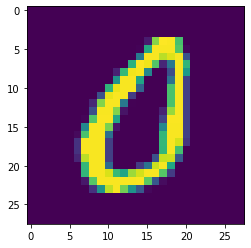

In [28]:
import matplotlib.image as mpimg
import matplotlib.pylab as plt

plt.imshow(source_batch_xs[batch][3].reshape((28,28)))

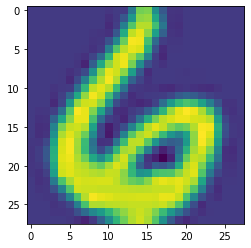

In [29]:

plt.imshow(target_train_images[0].reshape((28,28)))


In [36]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [39]:
cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [41]:
#Save all models

#Source discriminator
# serialize model to JSON
model_json = source_discriminator.to_json()
with open("source_discriminator.json", "w") as json_file: #GOOD ONE!
    json_file.write(model_json)
# serialize weights to HDF5
source_discriminator.save_weights("source_discriminator.h5")
print("Saved model to disk")

#Target discriminator
# serialize model to JSON
model_json = target_discriminator.to_json()
with open("target_discriminator.json", "w") as json_file: #GOOD ONE!
    json_file.write(model_json)
# serialize weights to HDF5
target_discriminator.save_weights("target_discriminator.h5")
print("Saved model to disk")


#Source encoder
# serialize model to JSON
model_json = source_encoder.to_json()
with open("source_encoder.json", "w") as json_file: #GOOD ONE!
    json_file.write(model_json)
# serialize weights to HDF5
source_encoder.save_weights("source_encoder.h5")
print("Saved model to disk")

#Target encoder
# serialize model to JSON
model_json = target_encoder.to_json()
with open("target_encoder.json", "w") as json_file: #GOOD ONE!
    json_file.write(model_json)
# serialize weights to HDF5
target_encoder.save_weights("target_encoder.h5")
print("Saved model to disk")

#Source classifier
# serialize model to JSON
model_json = source_classifier_model.to_json()
with open("source_classifier.json", "w") as json_file: #GOOD ONE!
    json_file.write(model_json)
# serialize weights to HDF5
source_classifier_model.save_weights("source_classifier.h5")
print("Saved model to disk")

#Target classifier
# serialize model to JSON
model_json = target_classifier_model.to_json()
with open("target_classifier.json", "w") as json_file: #GOOD ONE!
    json_file.write(model_json)
# serialize weights to HDF5
target_classifier_model.save_weights("target_classifier.h5")
print("Saved model to disk")

Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
Saved model to disk
